In [1]:
import tensorflow as tf
from tensorflow.python.tools import inspect_checkpoint as chkpt
print("Tensorflow version: ", tf.__version__)

from tensorflow.python import pywrap_tensorflow
from tensorflow.python.platform import app
from tensorflow.python.platform import flags
from tensorflow.keras.initializers import constant

from tensorflow.python import keras
print("Keras version: ", keras.__version__)

import numpy as np

Tensorflow version:  1.14.0
Keras version:  2.2.4-tf


In [2]:
"""Inception-v1 Inflated 3D ConvNet used for Kinetics CVPR paper.
 
The model is introduced in:
 
Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset
Joao Carreira, Andrew Zisserman
https://arxiv.org/abs/1705.07750v1
"""

from __future__ import print_function
from __future__ import absolute_import

import warnings

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv3D
from tensorflow.python.keras.layers import MaxPooling3D
from tensorflow.python.keras.layers import AveragePooling3D
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras.layers import GlobalAveragePooling3D

# from tensorflow.python.keras.engine.topology import get_source_inputs
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K

WEIGHTS_NAME = ['rgb_kinetics_only', 'flow_kinetics_only', 'rgb_imagenet_and_kinetics', 'flow_imagenet_and_kinetics']

# path to pretrained models with top (classification layer)
WEIGHTS_PATH = {
    'rgb_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels.h5',
    'flow_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels.h5',
    'rgb_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels.h5',
    'flow_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels.h5'
}

# path to pretrained models with no top (no classification layer)
WEIGHTS_PATH_NO_TOP = {
    'rgb_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'rgb_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5'
}


def _obtain_input_shape(input_shape,
                        default_frame_size,
                        min_frame_size,
                        default_num_frames,
                        min_num_frames,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate the model's input shape.
    (Adapted from `keras/applications/imagenet_utils.py`)

    # Arguments
        input_shape: either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_frame_size: default input frames(images) width/height for the model.
        min_frame_size: minimum input frames(images) width/height accepted by the model.
        default_num_frames: default input number of frames(images) for the model.
        min_num_frames: minimum input number of frames accepted by the model.
        data_format: image data format to use.
        require_flatten: whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: one of `None` (random initialization)
            or 'kinetics_only' (pre-training on Kinetics dataset).
            or 'imagenet_and_kinetics' (pre-training on ImageNet and Kinetics datasets).
            If weights='kinetics_only' or weights=='imagenet_and_kinetics' then
            input channels must be equal to 3.

    # Returns
        An integer shape tuple (may include None entries).

    # Raises
        ValueError: in case of invalid argument values.
    """
    if weights != 'kinetics_only' and weights != 'imagenet_and_kinetics' and input_shape and len(input_shape) == 4:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_num_frames, default_frame_size, default_frame_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_num_frames, default_frame_size, default_frame_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_num_frames, default_frame_size, default_frame_size)
        else:
            default_shape = (default_num_frames, default_frame_size, default_frame_size, 3)
    if (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics') and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting`include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape

    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 4:
                    raise ValueError(
                        '`input_shape` must be a tuple of four integers.')
                if input_shape[0] != 3 and (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics'):
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if input_shape[1] is not None and input_shape[1] < min_num_frames:
                    raise ValueError('Input number of frames must be at least ' +
                                     str(min_num_frames) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if ((input_shape[2] is not None and input_shape[2] < min_frame_size) or
                   (input_shape[3] is not None and input_shape[3] < min_frame_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_frame_size) + 'x' + str(min_frame_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 4:
                    raise ValueError(
                        '`input_shape` must be a tuple of four integers.')
                if input_shape[-1] != 3 and (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics'):
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if input_shape[0] is not None and input_shape[0] < min_num_frames:
                    raise ValueError('Input number of frames must be at least ' +
                                     str(min_num_frames) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if ((input_shape[1] is not None and input_shape[1] < min_frame_size) or
                   (input_shape[2] is not None and input_shape[2] < min_frame_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_frame_size) + 'x' + str(min_frame_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None, None)
            else:
                input_shape = (None, None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape


def conv3d_bn(x,
              filters,
              num_frames,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1, 1),
              use_bias = False,
              use_activation_fn = True,
              use_bn = True,
              name=None):
    """Utility function to apply conv3d + BN.

    # Arguments
        x: input tensor.
        filters: filters in `Conv3D`.
        num_frames: frames (time depth) of the convolution kernel.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv3D`.
        strides: strides in `Conv3D`.
        use_bias: use bias or not  
        use_activation_fn: use an activation function or not.
        use_bn: use batch normalization or not.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.

    # Returns
        Output tensor after applying `Conv3D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv3D(
        filters, (num_frames, num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=use_bias,
        name=conv_name)(x)

    if use_bn:
        if K.image_data_format() == 'channels_first':
            bn_axis = 1
        else:
            bn_axis = 4
        x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)

    if use_activation_fn:
        x = Activation('relu', name=name)(x)

    return x


def Inception_Inflated3d(include_top=True,
                weights=None,
                input_tensor=None,
                input_shape=None,
                dropout_prob=0.0,
                endpoint_logit=True,
                classes=400):
    """Instantiates the Inflated 3D Inception v1 architecture.

    Optionally loads weights pre-trained
    on Kinetics. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format='channels_last'` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    Note that the default input frame(image) size for this model is 224x224.

    # Arguments
        include_top: whether to include the the classification 
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or 'kinetics_only' (pre-training on Kinetics dataset only).
            or 'imagenet_and_kinetics' (pre-training on ImageNet and Kinetics datasets).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(NUM_FRAMES, 224, 224, 3)` (with `channels_last` data format)
            or `(NUM_FRAMES, 3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
            NUM_FRAMES should be no smaller than 8. The authors used 64
            frames per example for training and testing on kinetics dataset
            Also, Width and height should be no smaller than 32.
            E.g. `(64, 150, 150, 3)` would be one valid value.
        dropout_prob: optional, dropout probability applied in dropout layer
            after global average pooling layer. 
            0.0 means no dropout is applied, 1.0 means dropout is applied to all features.
            Note: Since Dropout is applied just before the classification
            layer, it is only useful when `include_top` is set to True.
        endpoint_logit: (boolean) optional. If True, the model's forward pass
            will end at producing logits. Otherwise, softmax is applied after producing
            the logits to produce the class probabilities prediction. Setting this parameter 
            to True is particularly useful when you want to combine results of rgb model
            and optical flow model.
            - `True` end model forward pass at logit output
            - `False` go further after logit to produce softmax predictions
            Note: This parameter is only useful when `include_top` is set to True.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if not (weights in WEIGHTS_NAME or weights is None or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or %s' % 
                         str(WEIGHTS_NAME) + ' ' 
                         'or a valid path to a file containing `weights` values')

    if weights in WEIGHTS_NAME and include_top and classes != 400:
        raise ValueError('If using `weights` as one of these %s, with `include_top`'
                         ' as true, `classes` should be 400' % str(WEIGHTS_NAME))

    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_frame_size=224, 
        min_frame_size=32, 
        default_num_frames=64,
        min_num_frames=8,
        data_format=K.image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 4

    # Downsampling via convolution (spatial and temporal)
    x = conv3d_bn(img_input, 64, 7, 7, 7, strides=(2, 2, 2), padding='same', name='Conv3d_1a_7x7')

    # Downsampling (spatial only)
    x = MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_2a_3x3')(x)
    x = conv3d_bn(x, 64, 1, 1, 1, strides=(1, 1, 1), padding='same', name='Conv3d_2b_1x1')
    x = conv3d_bn(x, 192, 3, 3, 3, strides=(1, 1, 1), padding='same', name='Conv3d_2c_3x3')

    # Downsampling (spatial only)
    x = MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_3a_3x3')(x)

    # Mixed 3b
    branch_0 = conv3d_bn(x, 64, 1, 1, 1, padding='same', name='Conv3d_3b_0a_1x1')

    branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_3b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 128, 3, 3, 3, padding='same', name='Conv3d_3b_1b_3x3')

    branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_3b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 32, 3, 3, 3, padding='same', name='Conv3d_3b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 32, 1, 1, 1, padding='same', name='Conv3d_3b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_3b')

    # Mixed 3c
    branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_0a_1x1')

    branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 192, 3, 3, 3, padding='same', name='Conv3d_3c_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_3c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 96, 3, 3, 3, padding='same', name='Conv3d_3c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_3c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_3c')


    # Downsampling (spatial and temporal)
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same', name='MaxPool2d_4a_3x3')(x)

    # Mixed 4b
    branch_0 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_4b_0a_1x1')

    branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_4b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 208, 3, 3, 3, padding='same', name='Conv3d_4b_1b_3x3')

    branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_4b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 48, 3, 3, 3, padding='same', name='Conv3d_4b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4b')

    # Mixed 4c
    branch_0 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4c_0a_1x1')

    branch_1 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 224, 3, 3, 3, padding='same', name='Conv3d_4c_1b_3x3')

    branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4c')

    # Mixed 4d
    branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_0a_1x1')

    branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 256, 3, 3, 3, padding='same', name='Conv3d_4d_1b_3x3')

    branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4d_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4d_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4d_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4d_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4d')

    # Mixed 4e
    branch_0 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4e_0a_1x1')

    branch_1 = conv3d_bn(x, 144, 1, 1, 1, padding='same', name='Conv3d_4e_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 288, 3, 3, 3, padding='same', name='Conv3d_4e_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4e_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4e_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4e_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4e_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4e')

    # Mixed 4f
    branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_4f_0a_1x1')

    branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4f_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_4f_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4f_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_4f_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4f_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_4f_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4f')


    # Downsampling (spatial and temporal)
    x = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same', name='MaxPool2d_5a_2x2')(x)

    # Mixed 5b
    branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_5b_0a_1x1')

    branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_5b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_5b_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_5b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_5b')

    # Mixed 5c
    branch_0 = conv3d_bn(x, 384, 1, 1, 1, padding='same', name='Conv3d_5c_0a_1x1')

    branch_1 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_5c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 384, 3, 3, 3, padding='same', name='Conv3d_5c_1b_3x3')

    branch_2 = conv3d_bn(x, 48, 1, 1, 1, padding='same', name='Conv3d_5c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_5c')

    if include_top:
        
#         print("Before AveragePool: ", x.shape)
        dim3 = x.shape[2]
        
        # Classification block
        x = AveragePooling3D((2, dim3, dim3), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)
        
#         print("After AveragePool: ", x.shape)
        
        x = Dropout(rate=dropout_prob)(x)

        x = conv3d_bn(x, classes, 1, 1, 1, padding='same', 
                use_bias=True, use_activation_fn=False, use_bn=False, name='Conv3d_6a_1x1')
 
        num_frames_remaining = int(x.shape[1])
    
#         print("Num frames remaining ", x.shape[1])
#         print("After 1x1 conv ", x.shape)
        
        x = Reshape((num_frames_remaining, classes))(x)
    
#         print("After Reshape ", x.shape)
        
        # logits (raw scores for each class)
        x = Lambda(lambda x: K.mean(x, axis=1, keepdims=False),
                   output_shape=lambda s: (s[0], s[2]))(x)
        
#         print("After mean: ", x.shape)

        if not endpoint_logit:
            x = Activation('softmax', name='prediction')(x)
    else:
        h = int(x.shape[2])
        w = int(x.shape[3])
        x = AveragePooling3D((2, h, w), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)



    inputs = img_input
    # create model
    model = Model(inputs, x, name='i3d_inception')

    # load weights
    if weights in WEIGHTS_NAME:
        if weights == WEIGHTS_NAME[0]:   # rgb_kinetics_only
            if include_top:
                weights_url = WEIGHTS_PATH['rgb_kinetics_only']
                model_name = 'i3d_inception_rgb_kinetics_only.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['rgb_kinetics_only']
                model_name = 'i3d_inception_rgb_kinetics_only_no_top.h5'

        elif weights == WEIGHTS_NAME[1]: # flow_kinetics_only
            if include_top:
                weights_url = WEIGHTS_PATH['flow_kinetics_only']
                model_name = 'i3d_inception_flow_kinetics_only.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['flow_kinetics_only']
                model_name = 'i3d_inception_flow_kinetics_only_no_top.h5'

        elif weights == WEIGHTS_NAME[2]: # rgb_imagenet_and_kinetics
            if include_top:
                weights_url = WEIGHTS_PATH['rgb_imagenet_and_kinetics']
                model_name = 'i3d_inception_rgb_imagenet_and_kinetics.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['rgb_imagenet_and_kinetics']
                model_name = 'i3d_inception_rgb_imagenet_and_kinetics_no_top.h5'

        elif weights == WEIGHTS_NAME[3]: # flow_imagenet_and_kinetics
            if include_top:
                weights_url = WEIGHTS_PATH['flow_imagenet_and_kinetics']
                model_name = 'i3d_inception_flow_imagenet_and_kinetics.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['flow_imagenet_and_kinetics']
                model_name = 'i3d_inception_flow_imagenet_and_kinetics_no_top.h5'

        downloaded_weights_path = get_file(model_name, weights_url, cache_subdir='models')
        model.load_weights(downloaded_weights_path)

        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first' and K.backend() == 'tensorflow':
            warnings.warn('You are using the TensorFlow backend, yet you '
                          'are using the Theano '
                          'image data format convention '
                          '(`image_data_format="channels_first"`). '
                          'For best performance, set '
                          '`image_data_format="channels_last"` in '
                          'your keras config '
                          'at ~/.keras/keras.json.')

    elif weights is not None:
        model.load_weights(weights)

    return model

In [3]:
def I3D_initializer(checkpoint_file, session):
    
    reader = pywrap_tensorflow.NewCheckpointReader(checkpoint_file)
    var_to_shape_map = reader.get_variable_to_shape_map()
    
    weights_init = 0
    
    #main loop
    for key in sorted(var_to_shape_map):
        tensor = reader.get_tensor(key)
        weights_init = weights_init + 1
        
        #parse the key for correct variable retrieval
        keywords = key.split("/")
        
        if keywords[0] == 'InceptionV1':
            
            #skip if logits
            if keywords[1] == 'Logits':
                weights_init = weights_init - 1
                continue;
            
            #check if convolution layer or mixed layer
            name_list = keywords[1].split("_")
            if len(name_list) == 3: #regular convolution layer
                
                base_name = 'Conv3d_' + name_list[1] + '_' + name_list[2]
                
                if keywords[2] == 'BatchNorm':
                    postfix = '_bn/' + keywords[3]
                    new_weights = np.array(tensor) #init bnorm weights
                    
                elif keywords[2] == 'weights':
                    postfix = '_conv'
                    
                    if (name_list[2] == '7x7'):
                        weights_init = weights_init - 1
                        continue;
                
                    new_weights = np.expand_dims(np.array(tensor), axis=0)
                    new_weights = np.repeat(new_weights, repeats=new_weights.shape[1], axis=0)
                    
            #mixed layer   
            else:
                base_name = 'Conv3d_' + name_list[1] + '_' + keywords[2].split("_")[1] + keywords[3].split("_")[1][1:] + '_' + keywords[3].split("_")[2]
                
                if keywords[4] == 'BatchNorm':
                    postfix = '_bn/' + keywords[5]
                    new_weights = np.array(tensor) #init bnorm weights
                
                elif keywords[4] == 'weights':
                    postfix = '_conv'
                    new_weights = np.expand_dims(np.array(tensor), axis=0)
                    new_weights = np.repeat(new_weights, repeats=new_weights.shape[1], axis=0)
            
            init = tf.constant_initializer(new_weights, verify_shape=True)
            tf.get_variable(base_name+postfix, shape=np.shape(new_weights), initializer=init)
        
        else:
            weights_init = weights_init - 1
            continue;
            
    session.run(tf.global_variables_initializer())
    
    #check if there are any uninitialized variables
    if(len(session.run(tf.report_uninitialized_variables())) == 0):
        print("Successfully initialized " + str(weights_init) + " variables.")

In [4]:
tf.reset_default_graph()
vol_model = Inception_Inflated3d(include_top=True,
                input_shape=(240, 240, 240, 1),
                dropout_prob=0.5,
                endpoint_logit=False,
                classes=2)

W0724 18:42:16.608527 140077983516416 deprecation.py:506] From /home/varung2/.local/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
vol_model.compile(optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0),
                          loss='binary_crossentropy',
                          metric=['accuracy'])

In [6]:
est_model = tf.keras.estimator.model_to_estimator(keras_model=vol_model, model_dir='est_dir')

# Data Preprocessing (Molly's)

In [7]:
import os
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline
# import cv2
from scipy import ndimage
import scipy

from skimage.segmentation import clear_border
from skimage.morphology import disk, dilation, binary_erosion, binary_closing, erosion, reconstruction, ball
from skimage.measure import label, regionprops

from bs4 import BeautifulSoup

import six.moves.urllib as urllib
import sys
import tarfile
import zipfile

from tensorflow import data

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from PIL import Image

import pandas as pd

import SimpleITK

In [8]:
ROOT = '/media/data/vaishnavi/LUNA'
IMG_PATH = 'images'
CSV_FILE = 'annotations.csv'

csv_path = os.path.join(ROOT, CSV_FILE)
print(csv_path)
csv = pd.read_csv(csv_path)

print (csv)
filenames = tf.constant([os.path.join(ROOT, IMG_PATH, uid+'.mhd') for uid in csv.seriesuid])
print(filenames)

/media/data/vaishnavi/LUNA/annotations.csv
                                              seriesuid      coordX  \
0     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421   
1     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651   
2     1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017   
3     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824   
4     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547   
5     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   90.931713   
6     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   89.540769   
7     1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...   81.509646   
8     1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...  105.055792   
9     1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760... -124.834262   
10    1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985... -106.901301   
11    1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...    2.263816   
12    1.3.6.1.4.1.14519.5.2.1.6279

/media/data/vaishnavi/LUNA/images/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd
(194, 512, 512)
(-157.67773, -311.67773, -438.4)
(0.64453125, 0.64453125, 1.7999999523162842)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


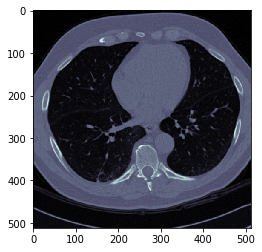

In [9]:
ct_path = os.path.join(ROOT, IMG_PATH, csv.seriesuid[0]+'.mhd')
print (ct_path)

ct_img = SimpleITK.ReadImage(ct_path)
img_array = SimpleITK.GetArrayFromImage(ct_img)
print (img_array.shape)

origin = ct_img.GetOrigin()
spacing = ct_img.GetSpacing()
direction = ct_img.GetDirection()

print (origin)
print (spacing)
print (direction)

plt.figure()
plt.imshow(img_array[90], cmap=plt.cm.bone)

In [10]:
FILE_DIR = '/media/data/vaishnavi/LIDC-IDRI/images/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/'
FILE_NAME = '000001.dcm'

ct_image = pydicom.dcmread(FILE_DIR+FILE_NAME)
print (ct_image)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.143451261327128179989900675595
(0008, 0020) Study Date                          DA: '20000101'
(0008, 0021) Series Date                         DA: '20000101'
(0008, 0022) Acquisition Date                    DA: '20000101'
(0008, 0023) Content Date                        DA: '20000101'
(0008, 0024) Overlay Date                        DA: '20000101'
(0008, 0025) Curve Date                          DA: '20000101'
(0008, 002a) Acquisition DateTime                DT: '20000101'
(0008, 0030) Study Time                          TM: ''
(0008, 0032) Acquisition Time                    TM: ''
(0008, 0033) Content Time                        TM: ''
(0008, 0050) Accession Number               

In [21]:
def load_xml(path): 
    
    with open(path, 'r') as xml_file:
        markup = xml_file.read()
    
    xml = BeautifulSoup(markup, features='xml')
    return xml

def find_dicom(patient_id):
    for sub_num in range(1, 1013): 
        file_name = '/media/data/vaishnavi/LIDC-IDRI/images/LIDC-IDRI-{:04d}/01-01-2000-30178/3000566-03192/'.format(sub_num)
        file_name = FILE_DIR+'{:04d}'
        ct_image = pydicom.dcmread(file_name)
        if ct_image.StudyInstanceUID == patient_id: 
            src_path = file_name
            return src_path

In [22]:
ROOT = ''

patientId = xml.LidcReadMessage.ResponseHeader.SeriesInstanceUid.text
print (xml.LidcReadMessage)

NameError: name 'xml' is not defined